In [2]:
import pandas as pd
import numpy as np
import os
import gc

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [3]:
NUM_SET = 20

In [4]:
def log_loss(labels, preds):
    return -1 * np.mean(labels * np.log(preds) + (1 - labels) * np.log(1 - preds))

def clip_preds(preds):
    return np.maximum(np.minimum(preds, 1 - 1e-15), 1e-15)

In [5]:
input_dir = '../_data/lish-moa'

trn_feat = pd.read_csv(os.path.join(input_dir, 'train_features.csv'))
tst_feat = pd.read_csv(os.path.join(input_dir, 'test_features.csv'))
target_scored = pd.read_csv(os.path.join(input_dir, 'train_targets_scored.csv'))
target_nonscored = pd.read_csv(os.path.join(input_dir, 'train_targets_nonscored.csv'))
sub = pd.read_csv(os.path.join(input_dir, 'sample_submission.csv'))

In [8]:
target_cols = [c for c in target_scored if c != 'sig_id']
print(len(target_cols))

206


In [10]:
'proteasome_inhibitor' in target_cols

True

In [6]:
trn_feat.sort_values(by='sig_id', inplace=True)
target_scored.sort_values(by='sig_id', inplace=True)
target_nonscored.sort_values(by='sig_id', inplace=True)

tst_feat.sort_values(by='sig_id', inplace=True)
sub.sort_values(by='sig_id', inplace=True)

In [7]:
gene_columns = [c for c in trn_feat.columns if c.startswith('g-')]
cell_columns = [c for c in trn_feat.columns if c.startswith('c-')]

scored_columns = [c for c in target_scored.columns if c != 'sig_id']
nonscored_columns = [c for c in target_nonscored.columns if c != 'sig_id']

In [8]:
cate_columns = ['cp_type', 'cp_time', 'cp_dose']

In [9]:
max_value = target_scored[scored_columns].mean().max()
max_index = target_scored[scored_columns].mean().values.argmax()
target = scored_columns[max_index]

print(target, ': positive rate =', max_value)

nfkb_inhibitor : positive rate = 0.03493743176282859


The original majority(negative) : minority(positive) ratio is about **100 : 3**

Thus, decompose the majority(negative) data into **20** smaller sets with sampling, such that the negative : positive rate will be about **5 : 3**.

### 1. Logistic Regression + Data decomposition

Data preparation:
1. Dummy coding
2. train test split
3. randomly decompose negative data set into 20 sets of equal size.

In [32]:
X = trn_feat.set_index('sig_id')
y = target_scored[['sig_id', target]].set_index('sig_id')[target]

In [106]:
X_dumm = pd.get_dummies(X, columns=cate_columns)

In [33]:
y.value_counts()

0    22982
1      832
Name: nfkb_inhibitor, dtype: int64

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(X_dumm, y, test_size=0.1, random_state=7)

print(X_trn.shape, y_trn.shape)
print(X_val.shape, y_val.shape)

In [112]:
pos_index = y_trn.loc[y_trn == 1].index.tolist()
neg_index = y_trn.loc[y_trn == 0].index.tolist()


num_neg = len(neg_index)
set_size = int(np.ceil(num_neg / NUM_SET))

np.random.shuffle(neg_index)
set_index_list = []

for i in range(NUM_SET):
    set_index_list.append(neg_index[i*set_size:(i+1)*set_size])

Train weak classifiers
* use logistic regression

Assemble predictions and evaluate performance

In [118]:
model_list = []
p_set_list = []
p_val_list = []

p_asm = np.zeros(len(y_val))

for i in range(NUM_SET):
    I = pos_index + set_index_list[i]
    np.random.shuffle(I)
    
    X_set = X_trn.loc[I]
    y_set = y_trn.loc[I]
    
    model = LogisticRegression()
    model.fit(X_set, y_set)
    
    model_list.append(model)
    
    p_set = clip_preds(model.predict(X_set))
    p_val = clip_preds(model.predict(X_val))
    
    logloss_set = log_loss(y_set, p_set)
    logloss_val = log_loss(y_val, p_val)
    
    print(f'Set {i+1} : set log-loss = {logloss_set}, valid log-loss = {logloss_val}')
    
    p_asm += (p_val / NUM_SET)
    p_set_list.append(p_set)
    p_val_list.append(p_val)

logloss_asm = log_loss(y_val, p_asm)
print(f'\nAssemble valid log-loss = {logloss_asm}')

Set 1 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.2620353726377695
Set 2 : set log-loss = 9.992007221626413e-16, valid log-loss = 1.9140299048717115
Set 3 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.0880328065963507
Set 4 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.001031355734031
Set 5 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.044531745481971
Set 6 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.044532081165191
Set 7 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.117033625900344
Set 8 : set log-loss = 9.992007221626413e-16, valid log-loss = 1.9720305364300381
Set 9 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.4215390396016825
Set 10 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.291035856258543
Set 11 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.320037011245756
Set 12 : set log-loss = 9.992007221626413e-16, valid log-loss = 2.1895344992690573
Set 13 : set log-lo

Normal logistic regression

In [120]:
lr = LogisticRegression()
lr.fit(X_trn, y_trn)

p_trn = lr.predict(X_trn)
p_val = lr.predict(X_val)

p_trn = clip_preds(p_trn)
p_val = clip_preds(p_val)

logloss_trn = log_loss(y_trn, p_trn)
logloss_val = log_loss(y_val, p_val)

print(logloss_trn, logloss_val)

0.025784827469139245 0.5655057380896574


### 2. GBM

In [58]:
X = trn_feat.set_index('sig_id')
y = target_scored[['sig_id', target]].set_index('sig_id')[target]

In [59]:
for c in cate_columns:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])

In [60]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.1, random_state=7)

print(X_trn.shape, y_trn.shape)
print(X_val.shape, y_val.shape)

(21432, 875) (21432,)
(2382, 875) (2382,)


In [62]:
D_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cate_columns)
D_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_columns)

In [153]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 7,
    'num_leaves': 70,
    'min_data_in_leaf': 20,
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.9,
    'neg_bagging_fraction': 0.05,
}

In [167]:
lgb_model = lgb.train(lgb_params, 
                      D_trn,
#                       feval=log_loss_eval,
                      valid_sets=[D_trn, D_val],
                      valid_names=['train', 'valid'],
                      categorical_feature=cate_columns,
                      num_boost_round=1000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.020699	valid's binary_logloss: 0.0451419
[100]	train's binary_logloss: 0.00555636	valid's binary_logloss: 0.0456743
[150]	train's binary_logloss: 0.00332954	valid's binary_logloss: 0.0570163
Early stopping, best iteration is:
[68]	train's binary_logloss: 0.0114959	valid's binary_logloss: 0.0414787


In [168]:
p_val = lgb_model.predict(X_val)

In [169]:
log_loss(y_val, p_val)

0.04147873474414674

In [63]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 24,
    'min_data_in_leaf': 20,
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.9,
    'neg_bagging_fraction': 0.05,
}

lgb_model = lgb.train(lgb_params, 
                      D_trn,
#                       feval=log_loss_eval,
                      valid_sets=[D_trn, D_val],
                      valid_names=['train', 'valid'],
                      categorical_feature=cate_columns,
                      num_boost_round=1000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.0841334	valid's binary_logloss: 0.0883566
[100]	train's binary_logloss: 0.0713465	valid's binary_logloss: 0.0803146
[150]	train's binary_logloss: 0.0632966	valid's binary_logloss: 0.0750331
[200]	train's binary_logloss: 0.0566888	valid's binary_logloss: 0.0703303
[250]	train's binary_logloss: 0.0514041	valid's binary_logloss: 0.0667222
[300]	train's binary_logloss: 0.0466528	valid's binary_logloss: 0.063368
[350]	train's binary_logloss: 0.0425977	valid's binary_logloss: 0.060467
[400]	train's binary_logloss: 0.0388749	valid's binary_logloss: 0.0578954
[450]	train's binary_logloss: 0.0355341	valid's binary_logloss: 0.0556014
[500]	train's binary_logloss: 0.0324455	valid's binary_logloss: 0.0533664
[550]	train's binary_logloss: 0.0293914	valid's binary_logloss: 0.0514023
[600]	train's binary_logloss: 0.026363	valid's binary_logloss: 0.0495137
[650]	train's binary_logloss: 0.0237457	valid's binary

#### 2.1 

In [64]:
X = trn_feat.set_index('sig_id')
y = target_scored[['sig_id', target]].set_index('sig_id')[target]

In [69]:
cate_columns = ['cp_type', 'cp_dose']

for c in cate_columns:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])

In [70]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.1, random_state=7)

print(X_trn.shape, y_trn.shape)
print(X_val.shape, y_val.shape)

(21432, 875) (21432,)
(2382, 875) (2382,)


In [72]:
D_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cate_columns)
D_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_columns)

In [73]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 24,
    'min_data_in_leaf': 20,
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.9,
    'neg_bagging_fraction': 0.05,
}

lgb_model = lgb.train(lgb_params, 
                      D_trn,
#                       feval=log_loss_eval,
                      valid_sets=[D_trn, D_val],
                      valid_names=['train', 'valid'],
                      categorical_feature=cate_columns,
                      num_boost_round=1000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.0841334	valid's binary_logloss: 0.0883566
[100]	train's binary_logloss: 0.0713465	valid's binary_logloss: 0.0803146
[150]	train's binary_logloss: 0.0632966	valid's binary_logloss: 0.0750331
[200]	train's binary_logloss: 0.0566888	valid's binary_logloss: 0.0703303
[250]	train's binary_logloss: 0.0514041	valid's binary_logloss: 0.0667222
[300]	train's binary_logloss: 0.0466528	valid's binary_logloss: 0.063368
[350]	train's binary_logloss: 0.0425977	valid's binary_logloss: 0.060467
[400]	train's binary_logloss: 0.0388749	valid's binary_logloss: 0.0578954
[450]	train's binary_logloss: 0.0355341	valid's binary_logloss: 0.0556014
[500]	train's binary_logloss: 0.0324455	valid's binary_logloss: 0.0533664
[550]	train's binary_logloss: 0.0293914	valid's binary_logloss: 0.0514023
[600]	train's binary_logloss: 0.0263629	valid's binary_logloss: 0.0495136
[650]	train's binary_logloss: 0.0237491	valid's binar

In [82]:
757 / 20675

0.0366142684401451

In [85]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 24,
    'min_data_in_leaf': 20,
#     'bagging_freq': 1,
#     'pos_bagging_fraction': 0.9,
#     'neg_bagging_fraction': 0.03,
}

lgb_model = lgb.train(lgb_params, 
                      D_trn,
#                       feval=log_loss_eval,
                      valid_sets=[D_trn, D_val],
                      valid_names=['train', 'valid'],
                      categorical_feature=cate_columns,
                      num_boost_round=1000,
                      early_stopping_rounds=10,
                      verbose_eval=10)

Training until validation scores don't improve for 10 rounds
[10]	train's binary_logloss: 0.110134	valid's binary_logloss: 0.104069
[20]	train's binary_logloss: 0.0924821	valid's binary_logloss: 0.0893216
[30]	train's binary_logloss: 0.0811045	valid's binary_logloss: 0.0797725
[40]	train's binary_logloss: 0.0726612	valid's binary_logloss: 0.0728113
[50]	train's binary_logloss: 0.0660094	valid's binary_logloss: 0.0673988
[60]	train's binary_logloss: 0.0602744	valid's binary_logloss: 0.0630478
[70]	train's binary_logloss: 0.0553557	valid's binary_logloss: 0.0594301
[80]	train's binary_logloss: 0.0511256	valid's binary_logloss: 0.0563111
[90]	train's binary_logloss: 0.0473992	valid's binary_logloss: 0.0536005
[100]	train's binary_logloss: 0.0441221	valid's binary_logloss: 0.0513151
[110]	train's binary_logloss: 0.041306	valid's binary_logloss: 0.0494025
[120]	train's binary_logloss: 0.0386863	valid's binary_logloss: 0.0477562
[130]	train's binary_logloss: 0.0363933	valid's binary_logloss:

In [87]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 7,
    'num_leaves': 70,
    'min_data_in_leaf': 20,
#     'bagging_freq': 1,
#     'pos_bagging_fraction': 0.9,
#     'neg_bagging_fraction': 0.05,
}

lgb_model = lgb.train(lgb_params, 
                      D_trn,
#                       feval=log_loss_eval,
                      valid_sets=[D_trn, D_val],
                      valid_names=['train', 'valid'],
                      categorical_feature=cate_columns,
                      num_boost_round=1000,
                      early_stopping_rounds=10,
                      verbose_eval=10)

Training until validation scores don't improve for 10 rounds
[10]	train's binary_logloss: 0.109985	valid's binary_logloss: 0.104051
[20]	train's binary_logloss: 0.0922511	valid's binary_logloss: 0.0892996
[30]	train's binary_logloss: 0.0807549	valid's binary_logloss: 0.0797091
[40]	train's binary_logloss: 0.072133	valid's binary_logloss: 0.0727466
[50]	train's binary_logloss: 0.0653025	valid's binary_logloss: 0.0673386
[60]	train's binary_logloss: 0.0592286	valid's binary_logloss: 0.0625983
[70]	train's binary_logloss: 0.0540691	valid's binary_logloss: 0.0588917
[80]	train's binary_logloss: 0.0494766	valid's binary_logloss: 0.0558522
[90]	train's binary_logloss: 0.045313	valid's binary_logloss: 0.0532503
[100]	train's binary_logloss: 0.0416544	valid's binary_logloss: 0.0509662
[110]	train's binary_logloss: 0.0383054	valid's binary_logloss: 0.0490338
[120]	train's binary_logloss: 0.0352944	valid's binary_logloss: 0.0474
[130]	train's binary_logloss: 0.0324737	valid's binary_logloss: 0.0

#### 2.2 LightGBM + decomposition

In [91]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 24,
    'min_data_in_leaf': 20,
}

In [88]:
pos_index = y_trn.loc[y_trn == 1].index.tolist()
neg_index = y_trn.loc[y_trn == 0].index.tolist()


num_neg = len(neg_index)
set_size = int(np.ceil(num_neg / NUM_SET))

np.random.shuffle(neg_index)
set_index_list = []

for i in range(NUM_SET):
    set_index_list.append(neg_index[i*set_size:(i+1)*set_size])

In [113]:
D_set = lgb.Dataset(X_set, label=y_set, categorical_feature=cate_columns)
D_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_columns)

In [120]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 24,
    'min_data_in_leaf': 20,
}

model_list = []
p_set_list = []
p_val_list = []

p_asm = np.zeros(len(y_val))

for i in range(NUM_SET):
    I = pos_index + set_index_list[i]
    np.random.shuffle(I)
    
    X_set = X_trn.loc[I]
    y_set = y_trn.loc[I]
    
    D_set = lgb.Dataset(X_set, label=y_set, categorical_feature=cate_columns)
    D_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_columns)
    
    model = lgb.train(lgb_params, 
                      D_set,
                      valid_sets=[D_set, D_val],
                      valid_names=['set', 'valid'],
                      num_boost_round=1500,
                      early_stopping_rounds=10,
                      verbose_eval=0,
                     )
    
    
    model_list.append(model)
    
    p_set = clip_preds(model.predict(X_set))
    p_val = clip_preds(model.predict(X_val))
    
    logloss_set = log_loss(y_set, p_set)
    logloss_val = log_loss(y_val, p_val)
    
    print(f'Set {i+1} : set log-loss = {logloss_set}, valid log-loss = {logloss_val}')
    
    p_asm += (p_val / NUM_SET)
    p_set_list.append(p_set)
    p_val_list.append(p_val)

logloss_asm = log_loss(y_val, p_asm)
print(f'\nAssemble valid log-loss = {logloss_asm}')

Set 1 : set log-loss = 0.004289107910202883, valid log-loss = 0.05612985476182848
Set 2 : set log-loss = 0.0037411831792250614, valid log-loss = 0.054099959021151084
Set 3 : set log-loss = 0.0055184935463940465, valid log-loss = 0.06426306119833129
Set 4 : set log-loss = 0.004808982671179445, valid log-loss = 0.06272048137819665
Set 5 : set log-loss = 0.004948970900312611, valid log-loss = 0.061710800569027675
Set 6 : set log-loss = 0.005100795274953932, valid log-loss = 0.06366805465172382
Set 7 : set log-loss = 0.004330591421659294, valid log-loss = 0.05847215936703586
Set 8 : set log-loss = 0.003984518829946974, valid log-loss = 0.05245457268197694
Set 9 : set log-loss = 0.004176529181024854, valid log-loss = 0.055255215136066134
Set 10 : set log-loss = 0.005113914430399332, valid log-loss = 0.057313768528676444
Set 11 : set log-loss = 0.0035720278631830625, valid log-loss = 0.05457176023298788
Set 12 : set log-loss = 0.0053681960245931925, valid log-loss = 0.05547713574104806
Set 1

In [121]:
log_loss(y_val, np.ones(len(y_val)) * y_trn.mean())

0.1400945659690275

### 3. Random Forest

### 4. Resampling

In [170]:
import sys

!{sys.executable} -m pip install imbalanced-learn

     |████████████████████████████████| 167 kB 537 kB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 3.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22
    Uninstalling scikit-learn-0.22:
      Successfully uninstalled scikit-learn-0.22
You should consider upgrading via the '/Users/wcc/01_Projects/04_Practice/05_GAN/venv3/bin/python -m pip install --upgrade pip' command.


#### 4.1 Over-sampling : SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [13]:
X = trn_feat.set_index('sig_id')
y = target_scored[['sig_id', target]].set_index('sig_id')[target]

In [14]:
X = pd.get_dummies(X, columns=cate_columns)

In [16]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.1, random_state=7)

print(X_trn.shape, y_trn.shape)
print(X_val.shape, y_val.shape)

(21432, 879) (21432,)
(2382, 879) (2382,)


In [31]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_trn, y_trn)

print(X_smote.shape, y_smote.shape)
print(y_smote.value_counts())

(41350, 879) (41350,)
1    20675
0    20675
Name: nfkb_inhibitor, dtype: int64


In [53]:
print(X_smote.shape, X_val.shape)

(41350, 879) (2382, 879)


In [34]:
D_trn = lgb.Dataset(X_smote, label=y_smote)
D_val = lgb.Dataset(X_val, label=y_val)

In [37]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 7,
    'num_leaves': 70,
    'min_data_in_leaf': 20,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
}

lgb_model = lgb.train(lgb_params,
                      D_trn,
                      valid_sets=[D_trn, D_val],
                      valid_names=['train', 'valid'],
                      num_boost_round=1000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.0209663	valid's binary_logloss: 0.0456096
[100]	train's binary_logloss: 0.00177925	valid's binary_logloss: 0.0412781
[150]	train's binary_logloss: 0.000136117	valid's binary_logloss: 0.0562002
Early stopping, best iteration is:
[76]	train's binary_logloss: 0.00570875	valid's binary_logloss: 0.0386952


In [51]:
X_trn2, X_val2, y_trn2, y_val2 = train_test_split(X_smote, y_smote, test_size=0.3, random_state=7)

D_trn2 = lgb.Dataset(X_trn2, label=y_trn2)
D_val2 = lgb.Dataset(X_val2, label=y_val2)

In [52]:
lgb_params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 4,
    'num_leaves': 40,
    'min_data_in_leaf': 50,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
}

lgb_model = lgb.train(lgb_params,
                      D_trn2,
                      valid_sets=[D_trn2, D_val2],
                      valid_names=['train', 'valid'],
                      num_boost_round=1000,
                      early_stopping_rounds=100,
                      verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.131876	valid's binary_logloss: 0.13129
[100]	train's binary_logloss: 0.0618685	valid's binary_logloss: 0.0644141
[150]	train's binary_logloss: 0.0350784	valid's binary_logloss: 0.0392938
[200]	train's binary_logloss: 0.0204008	valid's binary_logloss: 0.0248492
[250]	train's binary_logloss: 0.0121188	valid's binary_logloss: 0.0165397
[300]	train's binary_logloss: 0.00725927	valid's binary_logloss: 0.011282
[350]	train's binary_logloss: 0.00440663	valid's binary_logloss: 0.00805343
[400]	train's binary_logloss: 0.00280007	valid's binary_logloss: 0.00614296
[450]	train's binary_logloss: 0.00185131	valid's binary_logloss: 0.0048661
[500]	train's binary_logloss: 0.00128808	valid's binary_logloss: 0.00404823
[550]	train's binary_logloss: 0.000971803	valid's binary_logloss: 0.00358695
[600]	train's binary_logloss: 0.000766942	valid's binary_logloss: 0.00323616
[650]	train's binary_logloss: 0.000633184

#### 4.2 Over-sampling + Under sampling

In [ ]:
from imblearn.combine import SMOTEENN, SMOTETomek

In [30]:
smote_enn = SMOTEENN(random_state=0)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_trn, y_trn)

print(X_smoteenn.shape, y_smoteenn.shape)
print(y_smoteenn.value_counts())

(25445, 879) (25445,)
1    20675
0     4770
Name: nfkb_inhibitor, dtype: int64


In [54]:
D_trn = lgb.Dataset(X_smoteenn, label=y_smoteenn)
D_val = lgb.Dataset(X_val, label=y_val)

In [55]:
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 7,
    'num_leaves': 70,
    'min_data_in_leaf': 20,
    'bagging_freq': 1,
    'pos_bagging_fraction': 0.9,
    'neg_bagging_fraction': 0.2,
}

lgb_smoteenn = lgb.train(params,
                         D_trn,
                         valid_sets=[D_trn, D_val],
                         valid_names=['train', 'valid'],
                         num_boost_round=1000,
                         early_stopping_rounds=100,
                         verbose_eval=50)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.00876124	valid's binary_logloss: 0.721482
[100]	train's binary_logloss: 0.000834782	valid's binary_logloss: 0.570969
[150]	train's binary_logloss: 0.000132307	valid's binary_logloss: 0.477436
[200]	train's binary_logloss: 1.8951e-05	valid's binary_logloss: 0.407716
[250]	train's binary_logloss: 3.7517e-06	valid's binary_logloss: 0.34489
[300]	train's binary_logloss: 1.2996e-06	valid's binary_logloss: 0.3244
[350]	train's binary_logloss: 7.01789e-07	valid's binary_logloss: 0.320183
[400]	train's binary_logloss: 4.84757e-07	valid's binary_logloss: 0.312785
[450]	train's binary_logloss: 4.07381e-07	valid's binary_logloss: 0.319694
[500]	train's binary_logloss: 3.64842e-07	valid's binary_logloss: 0.319249
Early stopping, best iteration is:
[408]	train's binary_logloss: 4.62779e-07	valid's binary_logloss: 0.310544


In [ ]:
smote_tomek = SMOTETomek(random_state=0)

X_smotetomek, y_smotetomek = smote_tomek.fit_resample(X_trn, y_trn)

print(X_smotetomek.shape, y_smotetomek.shape)
print(y_smotetomek.value_counts())

### 5. NN

In [132]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [235]:
from matplotlib import pyplot as plt
from matplotlib import rcParams

def plot_loss(epoches, train_losses, valid_losses):
    rcParams['figure.figsize'] = (16, 6)
    
    plt.plot(epoches, train_losses, 'g', marker='o', label='train loss')
    plt.plot(epoches, valid_losses, 'r', marker='o', label='valid loss')
    plt.grid(True, 'both', linestyle='--')
    plt.legend(loc='best')
    plt.show()

In [129]:
X_dumm = pd.get_dummies(X, columns=cate_columns)

In [131]:
print(X_dumm.shape)
# print(X_dumm.head())

(23814, 877)


In [135]:
X_trn, X_val, y_trn, y_val = train_test_split(X_dumm, y, test_size=0.2)

print(X_trn.shape, y_trn.shape)
print(X_val.shape, y_val.shape)

(19051, 877) (19051,)
(4763, 877) (4763,)


In [139]:
dtype = torch.float32

class MoADataset(Dataset):
    def __init__(self, dtype, features, targets=None, feature_columns=None):
        self.dtype = dtype

        if isinstance(features, (pd.DataFrame, pd.Series)):
            if feature_columns is not None:
                features = features[feature_columns]
            features = features.values
        self.features = torch.tensor(features, dtype=self.dtype)
        self.feature_columns = feature_columns

        if targets is None:
            targets = -np.ones(self.features.shape[0])  # фиктивный таргет, если идет инференс модели
        elif isinstance(targets, (pd.DataFrame, pd.Series)):
            targets = targets.values
        self.targets = torch.tensor(targets, dtype=self.dtype)

    def __getitem__(self, i):
        return self.features[i], self.targets[i]
#         return {
#             'x': self.features[i],
#             'y': self.targets[i]
#         }

    def __len__(self):
        return self.features.shape[0]

In [154]:
pd.DataFrame(y_trn).shape

(19051, 1)

In [155]:
train_dataset = MoADataset(dtype, X_trn, pd.DataFrame(y_trn))
valid_dataset = MoADataset(dtype, X_val, pd.DataFrame(y_val))

In [133]:
batch_size = 2 ** 8
# num_workers = 0

In [156]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [185]:
class MoAModel(nn.Module):
    def __init__(self, dtype, num_in_features, num_out_featuers, dropout_rate=0.5):
        super().__init__()
        self.dtype = dtype
        self.net = nn.Sequential(
            nn.BatchNorm1d(num_in_features),
            
            nn.Linear(num_in_features, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(100, num_out_features)
        )
    
    def forward(self, x):
        return self.net(x)

In [183]:
def evaluation(model, train_dataloader, valid_dataloader):
    running_loss = 0.0
    cnt = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        cnt += 1

    train_loss = running_loss / cnt

    running_loss = 0.0
    cnt = 0
    for i, data in enumerate(valid_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        cnt += 1

    valid_loss = running_loss / cnt
    
    return train_loss, valid_loss

In [184]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel(dtype, num_in_features, num_out_features)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))

print('Finished Training')

[1,    10] loss: 0.423
[1,    20] loss: 0.235
[1,    30] loss: 0.142
[1,    40] loss: 0.104
[1,    50] loss: 0.082
[1,    60] loss: 0.068
[1,    70] loss: 0.059
train_loss = 0.052502, valid_loss = 0.057065

[2,    10] loss: 0.047
[2,    20] loss: 0.047
[2,    30] loss: 0.042
[2,    40] loss: 0.032
[2,    50] loss: 0.039
[2,    60] loss: 0.044
[2,    70] loss: 0.038
train_loss = 0.035846, valid_loss = 0.045871

[3,    10] loss: 0.037
[3,    20] loss: 0.036
[3,    30] loss: 0.037
[3,    40] loss: 0.037
[3,    50] loss: 0.028
[3,    60] loss: 0.031
[3,    70] loss: 0.023
train_loss = 0.028035, valid_loss = 0.041196

[4,    10] loss: 0.028
[4,    20] loss: 0.033
[4,    30] loss: 0.036
[4,    40] loss: 0.029
[4,    50] loss: 0.029
[4,    60] loss: 0.032
[4,    70] loss: 0.029
train_loss = 0.024356, valid_loss = 0.040499

[5,    10] loss: 0.022
[5,    20] loss: 0.022
[5,    30] loss: 0.022
[5,    40] loss: 0.022
[5,    50] loss: 0.029
[5,    60] loss: 0.024
[5,    70] loss: 0.025
train_loss 

#### 5.2 more epoches

In [187]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel(dtype, num_in_features, num_out_features)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))

print('Finished Training')

[1,    10] loss: 0.718
[1,    20] loss: 0.550
[1,    30] loss: 0.428
[1,    40] loss: 0.330
[1,    50] loss: 0.268
[1,    60] loss: 0.209
[1,    70] loss: 0.177
train_loss = 0.146991, valid_loss = 0.150431

[2,    10] loss: 0.139
[2,    20] loss: 0.127
[2,    30] loss: 0.113
[2,    40] loss: 0.092
[2,    50] loss: 0.089
[2,    60] loss: 0.077
[2,    70] loss: 0.074
train_loss = 0.066016, valid_loss = 0.067801

[3,    10] loss: 0.064
[3,    20] loss: 0.066
[3,    30] loss: 0.053
[3,    40] loss: 0.067
[3,    50] loss: 0.041
[3,    60] loss: 0.051
[3,    70] loss: 0.046
train_loss = 0.045224, valid_loss = 0.049422

[4,    10] loss: 0.041
[4,    20] loss: 0.048
[4,    30] loss: 0.037
[4,    40] loss: 0.042
[4,    50] loss: 0.044
[4,    60] loss: 0.040
[4,    70] loss: 0.039
train_loss = 0.039855, valid_loss = 0.046561

[5,    10] loss: 0.039
[5,    20] loss: 0.042
[5,    30] loss: 0.036
[5,    40] loss: 0.035
[5,    50] loss: 0.030
[5,    60] loss: 0.038
[5,    70] loss: 0.035
train_loss 

#### 5.2.2 dropout_rate = 0.1

In [ ]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel(dtype, num_in_features, num_out_features, dropout_rate=0.1)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []
epoches = [i for i in range(30)]

for epoch in epoches:  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Finished Training')

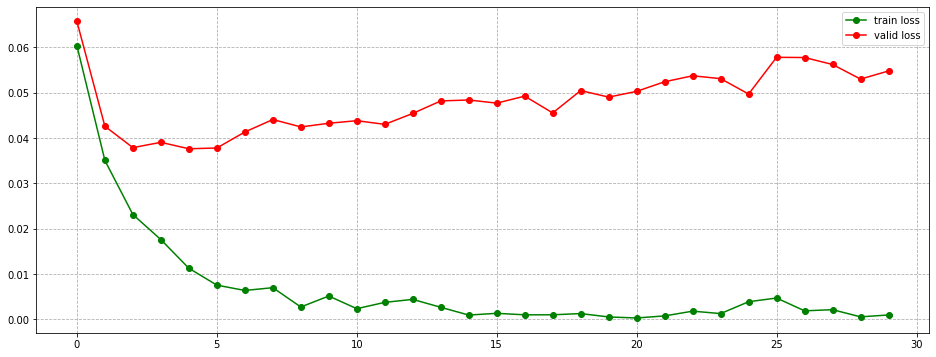

In [237]:
plot_loss(epoches, train_losses, valid_losses)

#### 5.3 without batch normalization

In [188]:
class MoAModel2(nn.Module):
    def __init__(self, dtype, num_in_features, num_out_featuers, dropout_rate=0.5):
        super().__init__()
        self.dtype = dtype
        self.net = nn.Sequential(
#             nn.BatchNorm1d(num_in_features),
            
            nn.Linear(num_in_features, 400),
#             nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(400, 200),
#             nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(100, num_out_features)
        )
    
    def forward(self, x):
        return self.net(x)

In [190]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel2(dtype, num_in_features, num_out_features)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))

print('Finished Training')

[1,    10] loss: 0.337
[1,    20] loss: 0.088
[1,    30] loss: 0.093
[1,    40] loss: 0.075
[1,    50] loss: 0.048
[1,    60] loss: 0.052
[1,    70] loss: 0.061
train_loss = 0.044542, valid_loss = 0.052863

[2,    10] loss: 0.048
[2,    20] loss: 0.041
[2,    30] loss: 0.028
[2,    40] loss: 0.047
[2,    50] loss: 0.049
[2,    60] loss: 0.039
[2,    70] loss: 0.033
train_loss = 0.035462, valid_loss = 0.049025

[3,    10] loss: 0.041
[3,    20] loss: 0.040
[3,    30] loss: 0.037
[3,    40] loss: 0.028
[3,    50] loss: 0.033
[3,    60] loss: 0.032
[3,    70] loss: 0.026
train_loss = 0.029317, valid_loss = 0.045471

[4,    10] loss: 0.031
[4,    20] loss: 0.026
[4,    30] loss: 0.024
[4,    40] loss: 0.032
[4,    50] loss: 0.022
[4,    60] loss: 0.028
[4,    70] loss: 0.027
train_loss = 0.025400, valid_loss = 0.046043

[5,    10] loss: 0.034
[5,    20] loss: 0.028
[5,    30] loss: 0.024
[5,    40] loss: 0.024
[5,    50] loss: 0.029
[5,    60] loss: 0.024
[5,    70] loss: 0.030
train_loss 

#### 5.4 deeper net 1

In [191]:
class MoAModel2(nn.Module):
    def __init__(self, dtype, num_in_features, num_out_featuers, dropout_rate=0.5):
        super().__init__()
        self.dtype = dtype
        self.net = nn.Sequential(
            nn.BatchNorm1d(num_in_features),
            
            nn.Linear(num_in_features, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(50, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(20, num_out_features)
        )
    
    def forward(self, x):
        return self.net(x)

In [192]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel2(dtype, num_in_features, num_out_features)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))

print('Finished Training')

[1,    10] loss: 0.730
[1,    20] loss: 0.672
[1,    30] loss: 0.613
[1,    40] loss: 0.604
[1,    50] loss: 0.552
[1,    60] loss: 0.520
[1,    70] loss: 0.482
train_loss = 0.453528, valid_loss = 0.448035

[2,    10] loss: 0.437
[2,    20] loss: 0.410
[2,    30] loss: 0.381
[2,    40] loss: 0.364
[2,    50] loss: 0.338
[2,    60] loss: 0.307
[2,    70] loss: 0.284
train_loss = 0.269983, valid_loss = 0.274550

[3,    10] loss: 0.266
[3,    20] loss: 0.254
[3,    30] loss: 0.235
[3,    40] loss: 0.219
[3,    50] loss: 0.203
[3,    60] loss: 0.192
[3,    70] loss: 0.184
train_loss = 0.173501, valid_loss = 0.171607

[4,    10] loss: 0.163
[4,    20] loss: 0.163
[4,    30] loss: 0.150
[4,    40] loss: 0.149
[4,    50] loss: 0.141
[4,    60] loss: 0.132
[4,    70] loss: 0.132
train_loss = 0.119703, valid_loss = 0.126797

[5,    10] loss: 0.118
[5,    20] loss: 0.115
[5,    30] loss: 0.110
[5,    40] loss: 0.111
[5,    50] loss: 0.107
[5,    60] loss: 0.096
[5,    70] loss: 0.092
train_loss 

In [198]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel2(dtype, num_in_features, num_out_features, dropout_rate=0.1)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))

print('Finished Training')

[1,    10] loss: 0.737
[1,    20] loss: 0.653
[1,    30] loss: 0.594
[1,    40] loss: 0.546
[1,    50] loss: 0.511
[1,    60] loss: 0.463
[1,    70] loss: 0.431
train_loss = 0.403217, valid_loss = 0.407900

[2,    10] loss: 0.399
[2,    20] loss: 0.366
[2,    30] loss: 0.344
[2,    40] loss: 0.320
[2,    50] loss: 0.305
[2,    60] loss: 0.281
[2,    70] loss: 0.264
train_loss = 0.250170, valid_loss = 0.252615

[3,    10] loss: 0.243
[3,    20] loss: 0.227
[3,    30] loss: 0.213
[3,    40] loss: 0.197
[3,    50] loss: 0.187
[3,    60] loss: 0.176
[3,    70] loss: 0.168
train_loss = 0.154736, valid_loss = 0.158895

[4,    10] loss: 0.153
[4,    20] loss: 0.147
[4,    30] loss: 0.136
[4,    40] loss: 0.127
[4,    50] loss: 0.116
[4,    60] loss: 0.118
[4,    70] loss: 0.110
train_loss = 0.105255, valid_loss = 0.108573

[5,    10] loss: 0.097
[5,    20] loss: 0.093
[5,    30] loss: 0.094
[5,    40] loss: 0.087
[5,    50] loss: 0.088
[5,    60] loss: 0.082
[5,    70] loss: 0.091
train_loss 

In [199]:
class MoAModel3(nn.Module):
    def __init__(self, dtype, num_in_features, num_out_featuers, dropout_rate=0.5):
        super().__init__()
        self.dtype = dtype
        self.net = nn.Sequential(
            nn.BatchNorm1d(num_in_features),

            nn.Linear(num_in_features, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(50, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(20, num_out_features)
        )
    
    def forward(self, x):
        return self.net(x)

In [238]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel3(dtype, num_in_features, num_out_features, dropout_rate=0.1)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []
epoches = [i for i in range(30)]

for epoch in epoches:  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Finished Training')

[1,    10] loss: 0.554
[1,    20] loss: 0.435
[1,    30] loss: 0.375
[1,    40] loss: 0.327
[1,    50] loss: 0.293
[1,    60] loss: 0.271
[1,    70] loss: 0.238
train_loss = 0.218866, valid_loss = 0.222320

[2,    10] loss: 0.205
[2,    20] loss: 0.191
[2,    30] loss: 0.182
[2,    40] loss: 0.168
[2,    50] loss: 0.160
[2,    60] loss: 0.142
[2,    70] loss: 0.138
train_loss = 0.127568, valid_loss = 0.132154

[3,    10] loss: 0.125
[3,    20] loss: 0.111
[3,    30] loss: 0.116
[3,    40] loss: 0.100
[3,    50] loss: 0.101
[3,    60] loss: 0.092
[3,    70] loss: 0.084
train_loss = 0.082615, valid_loss = 0.087189

[4,    10] loss: 0.085
[4,    20] loss: 0.073
[4,    30] loss: 0.080
[4,    40] loss: 0.064
[4,    50] loss: 0.063
[4,    60] loss: 0.069
[4,    70] loss: 0.059
train_loss = 0.061684, valid_loss = 0.066448

[5,    10] loss: 0.054
[5,    20] loss: 0.054
[5,    30] loss: 0.055
[5,    40] loss: 0.065
[5,    50] loss: 0.048
[5,    60] loss: 0.052
[5,    70] loss: 0.056
train_loss 

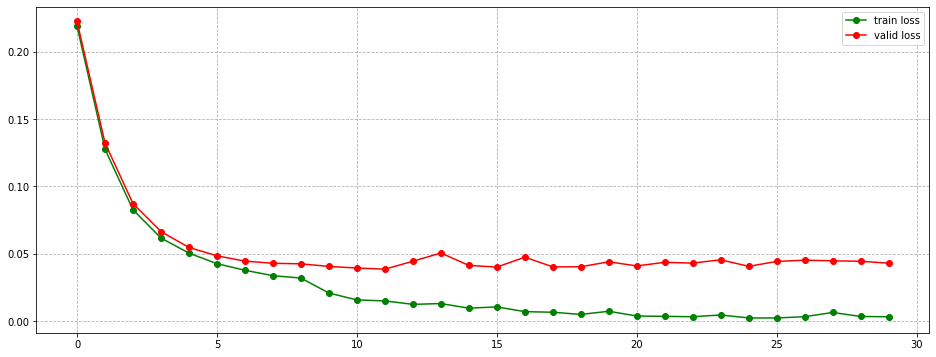

In [239]:
plot_loss(epoches, train_losses, valid_losses)

In [240]:
class MoAModel4(nn.Module):
    def __init__(self, dtype, num_in_features, num_out_featuers, dropout_rate=0.5):
        super().__init__()
        self.dtype = dtype
        self.net = nn.Sequential(
            nn.BatchNorm1d(num_in_features),

            nn.Linear(num_in_features, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
#             nn.Dropout(dropout_rate),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
#             nn.Dropout(dropout_rate),
            
            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
#             nn.Dropout(dropout_rate),

            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
#             nn.Dropout(dropout_rate),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
#             nn.Dropout(dropout_rate),

            nn.Linear(50, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
#             nn.Dropout(dropout_rate),

            nn.Linear(20, num_out_features)
        )
    
    def forward(self, x):
        return self.net(x)

In [241]:
num_in_features = X_trn.shape[1]
# num_hidden_features = 10
num_out_features = 1

model = MoAModel4(dtype, num_in_features, num_out_features, dropout_rate=0.1)

# print_every = 5
max_epoch = 100
lr = 1e-3

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []
epoches = [i for i in range(30)]

for epoch in epoches:  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    train_loss, valid_loss = evaluation(model, train_dataloader, valid_dataloader)
    print('train_loss = %f, valid_loss = %f\n' % (train_loss, valid_loss))
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Finished Training')

[1,    10] loss: 0.607
[1,    20] loss: 0.494
[1,    30] loss: 0.433
[1,    40] loss: 0.393
[1,    50] loss: 0.369
[1,    60] loss: 0.336
[1,    70] loss: 0.308
train_loss = 0.285819, valid_loss = 0.288053

[2,    10] loss: 0.277
[2,    20] loss: 0.257
[2,    30] loss: 0.239
[2,    40] loss: 0.219
[2,    50] loss: 0.201
[2,    60] loss: 0.191
[2,    70] loss: 0.181
train_loss = 0.165511, valid_loss = 0.169032

[3,    10] loss: 0.158
[3,    20] loss: 0.152
[3,    30] loss: 0.135
[3,    40] loss: 0.133
[3,    50] loss: 0.131
[3,    60] loss: 0.116
[3,    70] loss: 0.108
train_loss = 0.101247, valid_loss = 0.105967

[4,    10] loss: 0.093
[4,    20] loss: 0.094
[4,    30] loss: 0.095
[4,    40] loss: 0.091
[4,    50] loss: 0.081
[4,    60] loss: 0.075
[4,    70] loss: 0.076
train_loss = 0.069874, valid_loss = 0.074957

[5,    10] loss: 0.075
[5,    20] loss: 0.063
[5,    30] loss: 0.066
[5,    40] loss: 0.057
[5,    50] loss: 0.062
[5,    60] loss: 0.055
[5,    70] loss: 0.053
train_loss 

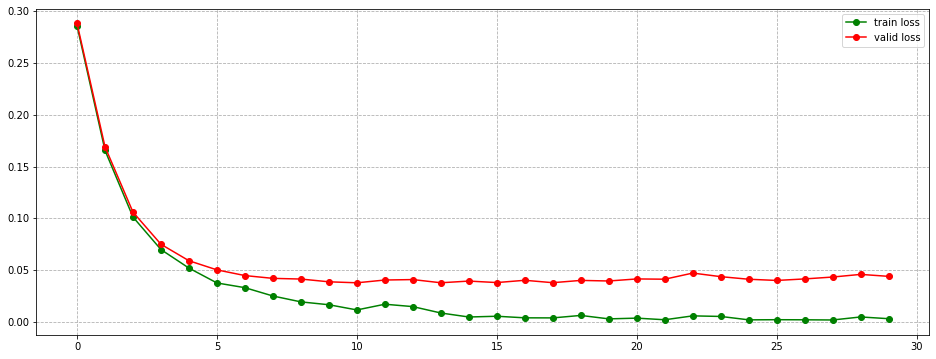

In [242]:
plot_loss(epoches, train_losses, valid_losses)